In [1]:
import sys
sys.path.append('..')
from astropy.io import fits
from inverse_problem.milne_edington.me import HinodeME
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Data downloading
Here https://csac.hao.ucar.edu/fg_download.php we need to select date and toogle level1 (big dataset, available with delay) and level 2 with parameters inversion.
After that data should be saved in directory (path_to_folder) and level1 folder renamed as file with inverted parameters, example:

 - 20140926_170005.fits
 - sp_20140926_170005

In [61]:
#Папка должна быть огранизована так, что в ней лежит фитс со второго уровня в том виде, в котором загружается с хиноды
path_to_folder = '../data/hinode_source'
#date as a list with year, month,day, hour 
date = ['2014','09','26','17']
sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')

In [62]:
sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]
sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
print(f'Number of files: {len(sp_lines)}')

Number of files: 873


In [63]:
def open_param_file(path_to_folder, date, print_ = True):
    paramfilelist = glob.glob(os.path.join(path_to_folder,f'*{date[0]}{date[1]}{date[2]}_{date[3]}*.fits'))
    if len(paramfilelist) == 1:
        refer = fits.open(paramfilelist[0])
        if print_:
            print('Open file with 36 available paramters, 11 will be selected')
            param_list = [1, 2, 3, 6, 8, 7, 33, 10, 5, 12, 13]
            print('\n'.join([refer[i].header['EXTNAME'] for i in param_list]))
        return refer
    else:
        print('Shold be one file, but what we got')
        print(paramfilelist )
        return 0
    

## Параметры

Ниже картиночки для разных параметров. Что мы отсюда должны вынести, кроме значений для генерации линий. Все таки пространственная корреляционная структура есть (именно это является поводом использовать сверточные сети). То есть когда мы смотрим на параметры как на картинку - видим не просто случайное поле, а картинку со структурами. Если хотеть это использовать, то и спектры надо организовывать таким образом, и тут нам уже понадобятся 3хмерные свертки (ширина_*_высота_*_число точек на линии_*_число линий). Но наверное это пока дорого и долго. Если мы игнорируем пространственную структуру, то можно пытаться строить многоуровневые модели: если посмотреть на интенсивность, то можно пытаться учить: пятно, фон, тень, а потом учить отдельно модели для пятно, фона и теней

In [64]:
refer = open_param_file(path_to_folder, ['2014','09','26','17'])

Open file with 36 available paramters, 11 will be selected
Field_Strength
Field_Inclination
Field_Azimuth
Doppler_Width
Damping
Line_Strength
Original_Continuum_Intensity
Source_Function_Gradient
Doppler_Shift2
Stray_Light_Fill_Factor
Stray_Light_Shift


In [65]:
refer[1].header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 /  IEEE single precision floating point          
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                  873 / Number of positions along axis 1               
NAXIS2  =                  512 / Number of positions along axis 2               
PCOUNT  =                    0 / No Group Parameters                            
GCOUNT  =                    1 / One Data Group                                 
EXTNAME = 'Field_Strength'     / Merlin : Field Strength                        

In [66]:
def plot_params(fits_file,ind):
    plt.imshow(refer[ind].data,  cmap='gray'); 
    name = refer[ind].header['EXTNAME']
    plt.title(f'{name}, size {refer[ind].data.shape}')

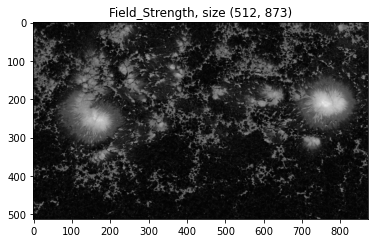

In [67]:
plot_params(refer,1)

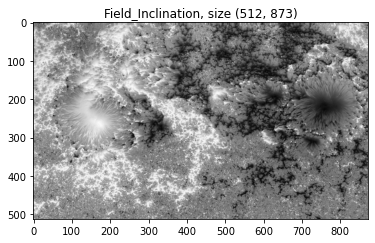

In [9]:
plot_params(refer,2)

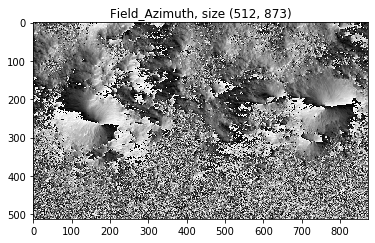

In [8]:
plot_params(refer,3)

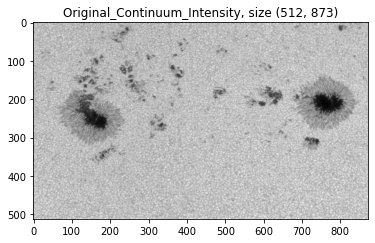

In [10]:
plot_params(refer,33)

## Real spectral lines

In [79]:
def open_spectrum_data(sp_folder, date, idx):
    """
    path should start from the folder included in level1 folder, with data year 
    only for this path_to_folder like this sp_20140926_170005
    """
    sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
    sp_path = glob.glob(f'{sp_path}/*/')[0]
    sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
    print(f'Number of files: {len(sp_lines)}')
    return fits.open(sp_lines[idx])
def real_spectra(spectra_file):
    """
    Extracting and plotting spectral lines from fits
    Why multiply to numbers?
    """
    real_I = spectra_file[0].data[0][:,56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][:,56:].astype('float64')*3
    real_U = spectra_file[0].data[2][:,56:].astype('float64')*3
    real_V = spectra_file[0].data[3][:,56:].astype('float64')*3
    return np.concatenate((real_I, real_Q, real_U, real_V), axis = 1)

def plot_spectrum(path_to_folder, date, idx_0, idx_1):
    """
    Plot spectrum, corresponding referens values of parameters and model spectrum
    idx_0 - index of line in one spectrum file (512), idx_1 - index of spectrum file sorted by time (873 in total)
    """
    refer = open_param_file(path_to_folder, date, print_=False)
    spectra_file = open_spectrum_data(sp_folder, date, idx_1)
    real_sp =  real_spectra(spectra_file)
    full_line = real_sp[idx_0,:]
    fig, ax = plt.subplots(2,2, figsize = (10,5))
    line_type = ['I','Q','U','V']
    param_list = [1, 2, 3, 6, 8, 7, 33, 10, 5, 12, 13]
    print('Real spectrum for parameters')
    print(', '.join([refer[i].header['EXTNAME']+f': {refer[i].data[idx_0,idx_1]:.2f}' for i in param_list]))

    for i in range(4):
        ax[i//2][i%2].plot(full_line[i*56:i*56+56]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.suptitle('Real spectrum', fontsize = 16, fontweight="bold")
    fig.set_tight_layout(tight = True)

    return refer,spectra_file, full_line
    
    
def plot_model_spectrum(refer, idx_0, idx_1, plot_=True):

    param_list = [1, 2, 3, 6, 8, 7, 33, 10, 5, 12, 13]
    param_vec  = np.array([refer[i].data[idx_0,idx_1] for i in param_list])
    obj = HinodeME(param_vec)
    profile = obj.compute_spectrum(with_ff=True, with_noise=True)
    fig, ax = plt.subplots(2,2, figsize = (10,5))
    line_type = ['I','Q','U','V']
    print('Model spectrum for parameters')
    print(', '.join([refer[i].header['EXTNAME']+f': {refer[i].data[idx_0,idx_1]:.2f}' for i in param_list]))

    for i in range(4):
        ax[i//2][i%2].plot(profile[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight = True)
    fig.suptitle('Model spectrum', fontsize = 16, fontweight="bold")

    return profile, obj    

Number of files: 873
Real spectrum for parameters
Field_Strength: 99.02, Field_Inclination: 88.33, Field_Azimuth: 92.80, Doppler_Width: 26.06, Damping: 0.19, Line_Strength: 13.03, Original_Continuum_Intensity: 25168.39, Source_Function_Gradient: 18629.20, Doppler_Shift2: 0.12, Stray_Light_Fill_Factor: 0.80, Stray_Light_Shift: 3.40


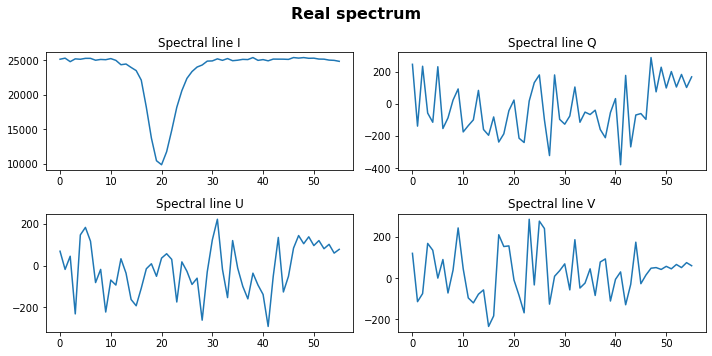

In [80]:
idx_0, idx_1 = 1, 1

_,_, real_line = plot_spectrum(path_to_folder, date, idx_0, idx_1)

Model spectrum for parameters
Field_Strength: 99.02, Field_Inclination: 88.33, Field_Azimuth: 92.80, Doppler_Width: 26.06, Damping: 0.19, Line_Strength: 13.03, Original_Continuum_Intensity: 25168.39, Source_Function_Gradient: 18629.20, Doppler_Shift2: 0.12, Stray_Light_Fill_Factor: 0.80, Stray_Light_Shift: 3.40

 !! Интенсивность вычисленная как сумма 6 и 7 параметра 43874.51, а максиму у рельных спектров 25384.0


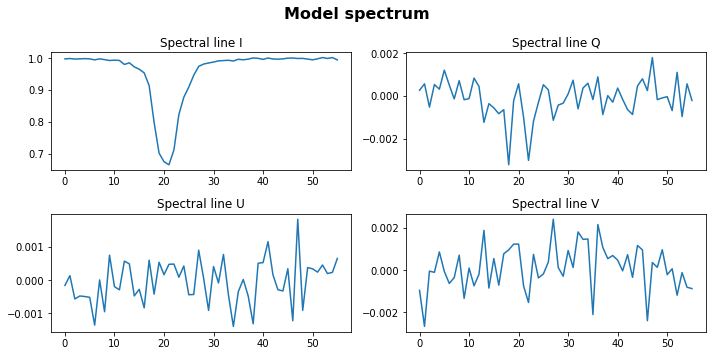

In [88]:
# Для этого профиля соответствуюший ему модельный спектр (параметры взяты из восстановленного по этим спектрам реферера)
profile, obj = plot_model_spectrum(refer, idx_0, idx_1)
print(f"\n !! Интенсивность вычисленная как сумма 6 и 7 параметра {obj.cont :.2f}, а максиму у рельных спектров {np.max(real_line)}")

# !!Вопросы!!
Сумма* параметров 6 и 7 - интенсивность. Она определяет величину профиля и при генерации синтетического спектра просто домножается в конце на посчитанный профиль единичной амплитуды. Не бьются данные модельные по которым мы учим и реальные. 

# Вопросы:
  - Как приводить к одному масштабу Хиноду и Модельные? Делить все на интенсивность? 
  
  Есть некоторые неведомые отличия между параметрами "Continuum intensity" и "Orginal continuum intensity" в reference. C первым хорошо соотносятся параметры "Source function" и "Source function gradient", которые мы ищем в инверсии. Со вторым хорошо сходится реальная величина профиля. 
  Думаю, лучший вариант - делить на максимальное значение профиля I
  
  - Надо бы потестить и посмотреть насколько совпадают спектры в разных диапазонах и заодно посмотреть как добавлять шум  
  
  Параметры для шума пробовал подобрать так: собирал статистику для значений в крайних точках профилей (для модельных Q, U, V это должен быть примерно 0, т.е. в реальных данных там остается только шум; для I накладывается еще величина континуума, но можно сравнивать с соседней точкой) - подробнее в About_Noise.ipynb. 
  Получилась следующая оценка: во всех случаях шумы имеют нормальное распределение, дисперсия:
  для I: 109, для Q и U: 28, для V: 44
  
  - нормировка, все спектры в разном масштабе, если их пускаем в каналы сверток - это не большая проблема, но все равно - считаем градиенты, надо приводить к одному масштабу.  Если собираем в один
  
  Есть вариант вычитать из реального (уже нормированного) профиля некий "средний" профиль.
  